## Winds Comparison

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from scipy.io import loadmat
import numpy as np
import re
from xml.etree import ElementTree as ET
from matplotlib.path import Path
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [3]:
## Functions
## kml to struct
def kml2struct(kml_file):
    """
    Import a .kml file as a list of dictionary structures with fields:
    Geometry, Name, Description, Lon, Lat, and BoundingBox.
    """
    # Read the KML file
    try:
        with open(kml_file, 'r', encoding='utf-8') as file:
            txt = file.read()
    except Exception as e:
        raise FileNotFoundError(f"Unable to open file {kml_file}: {e}")

    # Regular expression to match Placemark tags
    expr = r"<Placemark.+?>.+?</Placemark>"
    object_strings = re.findall(expr, txt, re.DOTALL)
    
    kml_struct = []

    for obj_str in object_strings:
        # Extract Name
        name_match = re.search(r"<name.*?>(.*?)</name>", obj_str, re.DOTALL)
        name = name_match.group(1).strip() if name_match else "undefined"

        # Extract Description
        desc_match = re.search(r"<description.*?>(.*?)</description>", obj_str, re.DOTALL)
        desc = desc_match.group(1).strip() if desc_match else ""

        # Determine Geometry Type
        geometry = ""
        if "<Point" in obj_str:
            geometry = "Point"
        elif "<LineString" in obj_str:
            geometry = "Line"
        elif "<Polygon" in obj_str:
            geometry = "Polygon"

        # Extract Coordinates
        coord_match = re.search(r"<coordinates.*?>(.*?)</coordinates>", obj_str, re.DOTALL)
        if not coord_match:
            continue  # Skip if no coordinates are found
        coord_str = coord_match.group(1).strip()
        coord_list = np.array([list(map(float, coord.split(','))) for coord in coord_str.split()])

        # Separate Lon, Lat, and handle Polygons
        lon = coord_list[:, 0]
        lat = coord_list[:, 1]
        if geometry == "Polygon":
            # Close the polygon by appending NaN
            lon = np.append(lon, np.nan)
            lat = np.append(lat, np.nan)

        # Create BoundingBox
        bounding_box = [[lon.min(), lat.min()], [lon.max(), lat.max()]]

        # Append to kml_struct
        kml_struct.append({
            "Geometry": geometry,
            "Name": name,
            "Description": desc,
            "Lon": lon,
            "Lat": lat,
            "BoundingBox": bounding_box
        })

    return kml_struct

In [4]:
# Load the KML file to get the polygon boundary
arch_kml_zona1 = "../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/BK150km.kml"
R1 = kml2struct(arch_kml_zona1)

# Extract Lon and Lat from the first polygon
lonb1 = R1[0]["Lon"]
latb1 = R1[0]["Lat"]

## Lon and lat for the whole dataset
lat = np.linspace(-33.0, 10.03286, 542).reshape(542, 1)  # Reshape to match eta_rho
lon = np.linspace(-118.9083, -68.90833, 602).reshape(1, 602)  # Reshape to match xi_rho

lats, lons = np.meshgrid(lat.flatten(), lon.flatten(), indexing="ij")

LON=lons
LAT=lats
# Create a path from the polygon coordinates
polygon = Path(np.column_stack((lonb1, latb1)))

# Flatten the LON and LAT to create coordinate pairs
lonlat_points = np.column_stack((LON.ravel(), LAT.ravel()))

# Check which points are inside the polygon
mask = polygon.contains_points(lonlat_points).reshape(LON.shape)

# Convert the mask to NaN for the outshore region
inshore_mask = np.where(mask, 1, np.nan)

In [5]:
ds = xr.open_dataset('../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/data/avg_Y1990M01.nc', 
                     chunks = {'time':1})
time_old = pd.date_range(start='1990-01', end='2011-01', freq='M')

/tmp/ipykernel_903412/2124787716.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_old = pd.date_range(start='1990-01', end='2011-01', freq='M')


### Old Wind NCEP2

In [6]:
old_w = loadmat("../../NHCS/Processed/old_winds.mat")
print(old_w.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Taux', 'Tauy', 'None', 'uwind', 'vwind', '__function_workspace__'])


In [7]:
oldwinds_ds = xr.Dataset(
    data_vars={
        'uwind': (("time", "lat","lon"), old_w['uwind'].transpose(2, 1, 0)),
        'vwind':(("time", "lat","lon"), old_w['vwind'].transpose(2, 1, 0))
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time_old
}
)

oldwinds_ds

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 252, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float32 2kB -118.9 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float32 2kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
Data variables:
    uwind    (time, lat, lon) float64 658MB -3.11 -3.106 -3.103 ... nan nan nan
    vwind    (time, lat, lon) float64 658MB -0.01107 0.009172 ... nan nan

In [8]:
oldwinds_ds['uvwind'] = np.sqrt(oldwinds_ds.uwind**2 + oldwinds_ds.vwind**2)
oldwinds_ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 252, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float32 2kB -118.9 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float32 2kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
Data variables:
    uwind    (time, lat, lon) float64 658MB -3.11 -3.106 -3.103 ... nan nan nan
    vwind    (time, lat, lon) float64 658MB -0.01107 0.009172 ... nan nan
    uvwind   (time, lat, lon) float64 658MB 3.11 3.106 3.103 3.1 ... nan nan nan

In [9]:
oldwinds_ds_cut = oldwinds_ds * inshore_mask
oldwinds_ds_cut = oldwinds_ds_cut.sel(lat=slice(-16,-5),lon=slice(-84,-73))

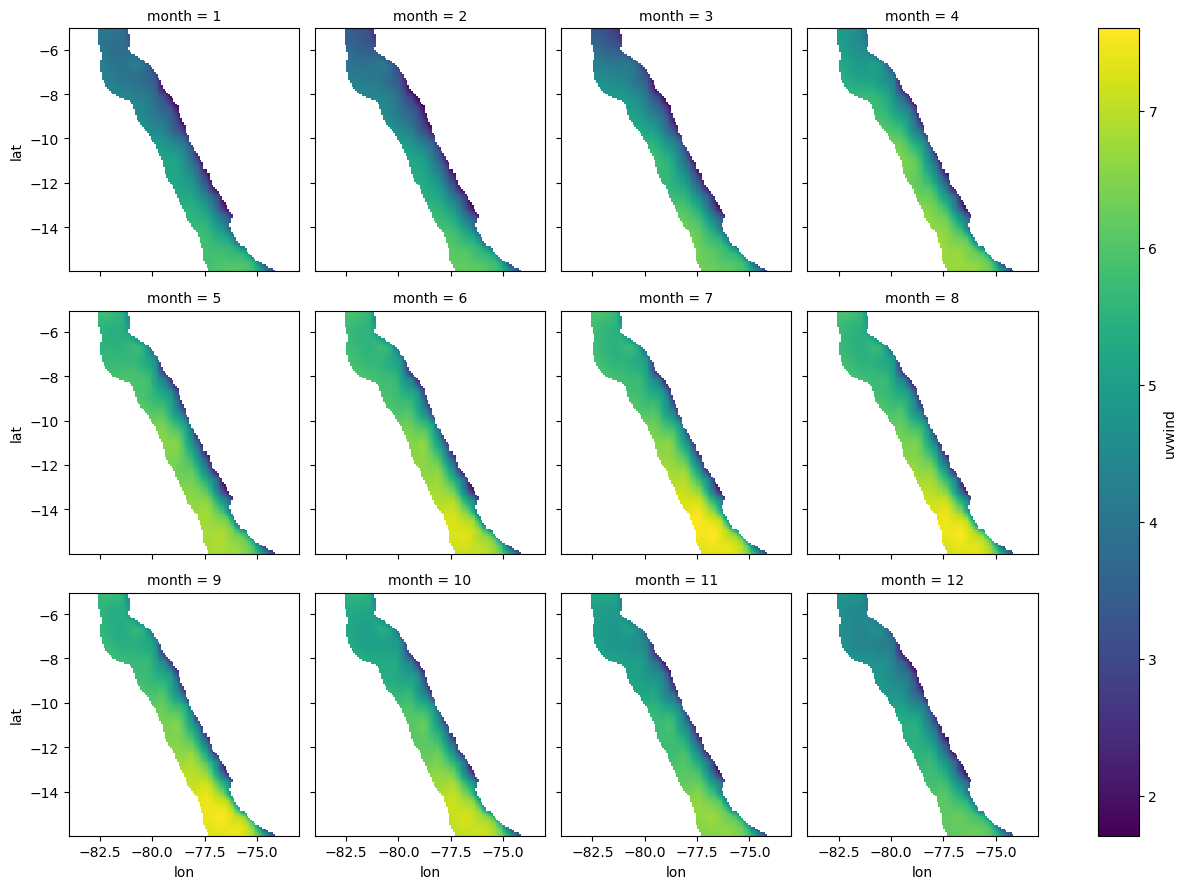

In [10]:
oldwind_clim = oldwinds_ds_cut.groupby('time.month').mean(dim='time')

oldwind_clim['uvwind'].sel(lat=slice(-16,-5),lon=slice(-84,-73)).plot(
    x='lon', y='lat',  # Plot longitude on x-axis and latitude on y-axis
    col='month',        # Create subplots for each time step
    col_wrap=4,
)

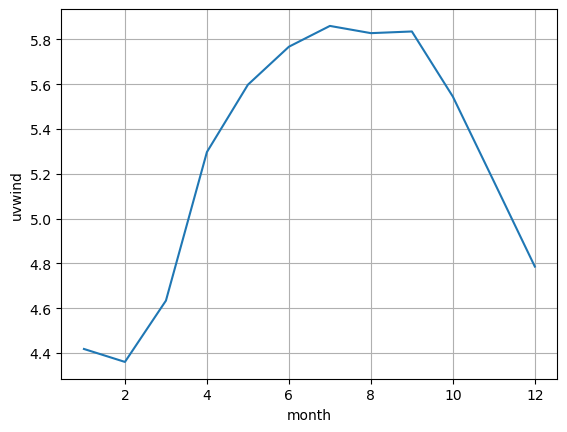

In [11]:
uvwind_old = oldwind_clim.uvwind
uvwind_old.mean(dim=('lon','lat'), skipna=True).plot()
plt.grid(True)

### New hindcast ERA5

In [12]:
new_w = loadmat("../../NHCS/Processed/new_winds.mat")
print(new_w.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Taux', 'Tauy', 'None', 'uwind', 'vwind', '__function_workspace__'])


In [13]:
time_new = pd.date_range(start='1980-01', end='2016-01', freq='M')

/tmp/ipykernel_903412/4041368635.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_new = pd.date_range(start='1980-01', end='2016-01', freq='M')


In [14]:
newwinds_ds = xr.Dataset(
    data_vars={
        'uwind': (("time", "lat","lon"), new_w['uwind'].transpose(2, 1, 0)),
        'vwind':(("time", "lat","lon"), new_w['vwind'].transpose(2, 1, 0))
    },
    coords = {
        'lon':ds.lon_rho.compute().values[0,:],
        'lat':ds.lat_rho.compute().values[:,0],
        'time':time_new
}
)

newwinds_ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float32 2kB -118.9 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float32 2kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    uwind    (time, lat, lon) float64 1GB 1.432 1.435 1.439 ... nan nan nan
    vwind    (time, lat, lon) float64 1GB -0.9696 -0.999 -1.031 ... nan nan nan

In [15]:
newwinds_ds['uvwind'] = np.sqrt(newwinds_ds.uwind**2 + newwinds_ds.vwind**2)
newwinds_ds

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 432, lat: 542, lon: 602)
Coordinates:
  * lon      (lon) float32 2kB -118.9 -118.9 -118.8 ... -69.03 -68.95 -68.87
  * lat      (lat) float32 2kB -33.0 -32.93 -32.86 -32.79 ... 9.869 9.951 10.03
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
Data variables:
    uwind    (time, lat, lon) float64 1GB 1.432 1.435 1.439 ... nan nan nan
    vwind    (time, lat, lon) float64 1GB -0.9696 -0.999 -1.031 ... nan nan nan
    uvwind   (time, lat, lon) float64 1GB 1.729 1.749 1.77 1.792 ... nan nan nan

In [16]:
newwinds_ds_cut = newwinds_ds * inshore_mask
newwinds_ds_cut = newwinds_ds_cut.sel(lat=slice(-16,-5),lon=slice(-84,-73))

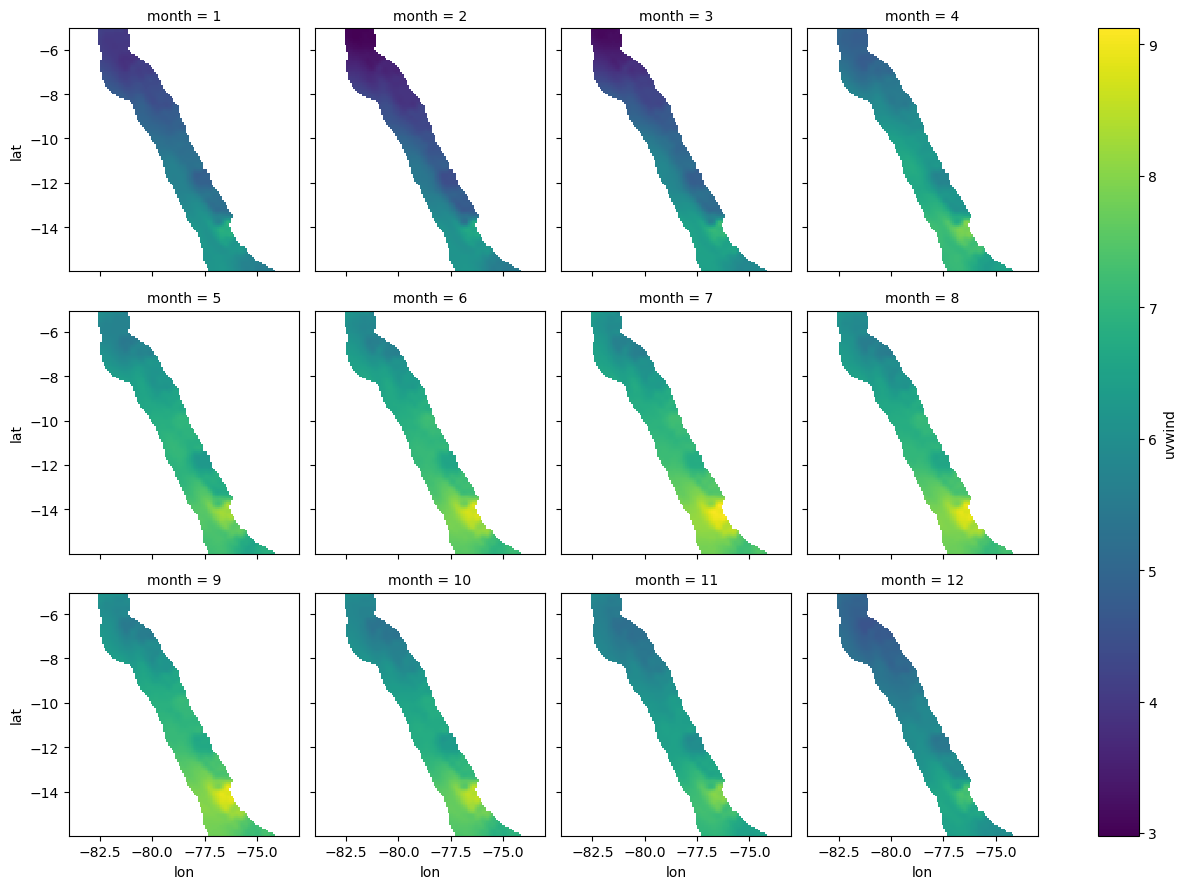

In [17]:
newwind_clim = newwinds_ds_cut.groupby('time.month').mean(dim='time')

newwind_clim['uvwind'].sel(lat=slice(-16,-5),lon=slice(-84,-73)).plot(
    x='lon', y='lat',  # Plot longitude on x-axis and latitude on y-axis
    col='month',        # Create subplots for each time step
    col_wrap=4,
)

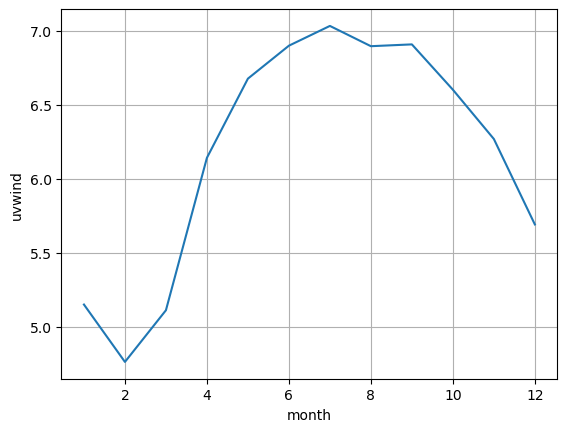

In [18]:
uvwind_new = newwind_clim.uvwind
uvwind_new.mean(dim=('lon','lat'), skipna=True).plot()
plt.grid(True)

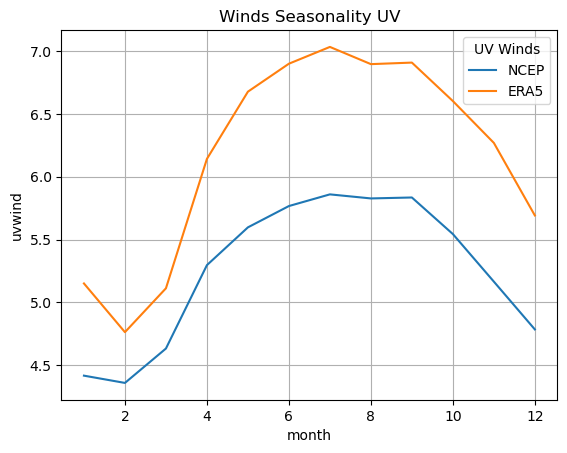

In [19]:
uvwind_old.mean(dim=('lon','lat'), skipna=True).plot(label='NCEP')
uvwind_new.mean(dim=('lon','lat'), skipna=True).plot(label='ERA5')
plt.grid(True)
plt.title('Winds Seasonality UV')
plt.legend(title='UV Winds', bbox_to_anchor=(1, 1))
# plt.savefig('Figures/Winds_season_compare'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')


In [20]:
old_ts_cut = oldwinds_ds * inshore_mask
old_ts = old_ts_cut.sel(lat=slice(-16,-5),lon=slice(-84,-73))

new_ts_cut = newwinds_ds * inshore_mask
new_ts = new_ts_cut.sel(lat=slice(-16,-5),lon=slice(-84,-73))

In [21]:
# old_ts = oldwinds_ds * inshore_mask
# new_ts = newwinds_ds * inshore_mask


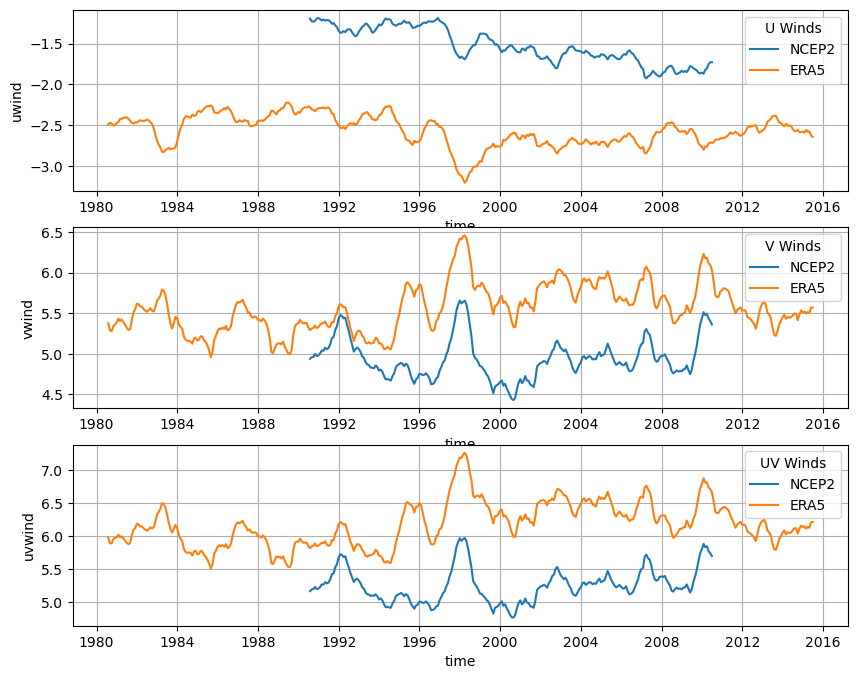

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,8))
old_ts.mean(dim=('lon','lat'), skipna=True).rolling(time=13,center=True).mean().uwind.plot(ax=axes[0],label='NCEP2')
new_ts.mean(dim=('lon','lat'), skipna=True).rolling(time=13,center=True).mean().uwind.plot(ax=axes[0],label='ERA5')
axes[0].grid(True)
axes[0].legend(title='U Winds', bbox_to_anchor=(1, 1))

old_ts.mean(dim=('lon','lat'), skipna=True).rolling(time=13,center=True).mean().vwind.plot(ax=axes[1],label='NCEP2')
new_ts.mean(dim=('lon','lat'), skipna=True).rolling(time=13,center=True).mean().vwind.plot(ax=axes[1],label='ERA5')
axes[1].grid(True)
axes[1].legend(title='V Winds', bbox_to_anchor=(1, 1))

old_ts.mean(dim=('lon','lat'), skipna=True).rolling(time=13,center=True).mean().uvwind.plot(ax=axes[2],label='NCEP2')
new_ts.mean(dim=('lon','lat'), skipna=True).rolling(time=13,center=True).mean().uvwind.plot(ax=axes[2],label='ERA5')
axes[2].grid(True)
axes[2].legend(title='UV Winds', bbox_to_anchor=(1, 1))

# plt.savefig('Figures/winds_comparison'+'.png', format='png', dpi=300, transparent=False, bbox_inches='tight')


### JRA winds

In [23]:
# pip install cfgrib

In [24]:
ds_tuto = xr.tutorial.load_dataset("era5-2mt-2019-03-uk.grib", engine="cfgrib")

In [25]:
JRApath='/gxfs_work/geomar/smomw662/NHCS/Winds_input/JRA/'
ds_JRA = xr.load_dataset(JRApath+"anl_surf125.033_ugrd.1958010100_1958123118", engine="cfgrib")
ds_JRA

<xarray.Dataset> Size: 244MB
Dimensions:            (time: 1460, latitude: 145, longitude: 288)
Coordinates:
    number             int64 8B 0
  * time               (time) datetime64[ns] 12kB 1958-01-01 ... 1958-12-31T1...
    step               timedelta64[ns] 8B 00:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 1kB 90.0 88.75 87.5 ... -88.75 -90.0
  * longitude          (longitude) float64 2kB -1.25 0.0 1.25 ... 356.2 357.5
    valid_time         (time) datetime64[ns] 12kB 1958-01-01 ... 1958-12-31T1...
Data variables:
    u10                (time, latitude, longitude) float32 244MB 0.9809 ... -...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             rjtd
    GRIB_centreDescription:  Japanese Meteorological Agency - Tokyo
    GRIB_subCentre:          241
    Conventions:             CF-1.7
    institution:             Japanese Meteorological Agency - Tokyo
    history:                 2025-03-10T14:53 GRIB to CDM+CF via cfgrib-0.9.1...

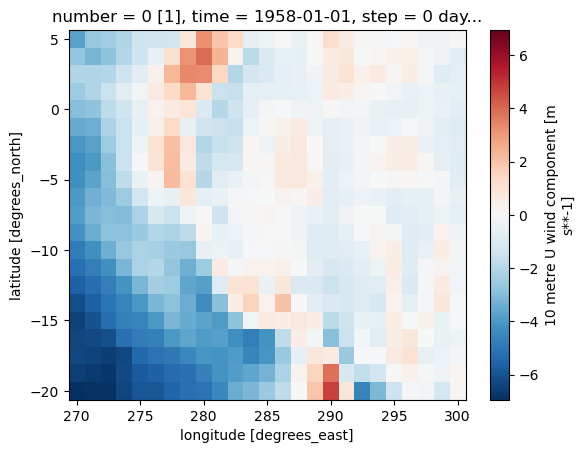

In [26]:
ds_JRA.isel(time=0).u10.sel(latitude=slice(5, -20), longitude=slice(-90+360, -60+360)).plot()

In [27]:
ds_JRA2 = xr.load_dataset(JRApath+"anl_surf125.033_ugrd.1958010100_1958123118", engine="cfgrib")
ds_JRA2
# 

<xarray.Dataset> Size: 244MB
Dimensions:            (time: 1460, latitude: 145, longitude: 288)
Coordinates:
    number             int64 8B 0
  * time               (time) datetime64[ns] 12kB 1958-01-01 ... 1958-12-31T1...
    step               timedelta64[ns] 8B 00:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 1kB 90.0 88.75 87.5 ... -88.75 -90.0
  * longitude          (longitude) float64 2kB -1.25 0.0 1.25 ... 356.2 357.5
    valid_time         (time) datetime64[ns] 12kB 1958-01-01 ... 1958-12-31T1...
Data variables:
    u10                (time, latitude, longitude) float32 244MB 0.9809 ... -...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             rjtd
    GRIB_centreDescription:  Japanese Meteorological Agency - Tokyo
    GRIB_subCentre:          241
    Conventions:             CF-1.7
    institution:             Japanese Meteorological Agency - Tokyo
    history:                 2025-03-10T14:53 GRIB to CDM+CF via cfgrib-0.9.1...

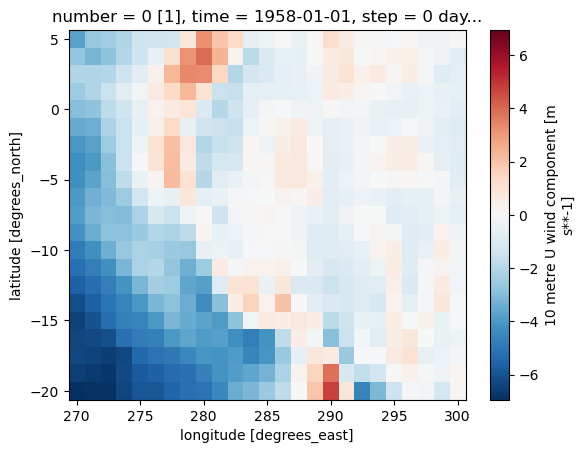

In [28]:
ds_JRA2.isel(time=0).u10.sel(latitude=slice(5, -20), longitude=slice(-90+360, -60+360)).plot()

## Interpolation 

In [29]:
ds = xr.open_dataset('../../NHCS/hincast_1980-2015/croco_avg_Y1980M01.nc', 
                     chunks = {'time':1})
ds

<xarray.Dataset> Size: 891MB
Dimensions:     (xi_rho: 602, xi_u: 601, eta_rho: 542, eta_v: 541, s_rho: 32,
                 s_w: 33, time: 1, auxil: 4)
Coordinates: (12/13)
  * xi_rho      (xi_rho) float64 5kB 1.0 2.0 3.0 4.0 ... 599.0 600.0 601.0 602.0
  * xi_u        (xi_u) float64 5kB 1.5 2.5 3.5 4.5 ... 598.5 599.5 600.5 601.5
  * eta_rho     (eta_rho) float64 4kB 1.0 2.0 3.0 4.0 ... 540.0 541.0 542.0
  * eta_v       (eta_v) float64 4kB 1.5 2.5 3.5 4.5 ... 538.5 539.5 540.5 541.5
  * s_rho       (s_rho) float64 256B -0.9844 -0.9531 ... -0.04688 -0.01562
  * s_w         (s_w) float64 264B -1.0 -0.9688 -0.9375 ... -0.0625 -0.03125 0.0
    ...          ...
    lat_rho     (eta_rho, xi_rho) float64 3MB dask.array<chunksize=(542, 602), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float64 3MB dask.array<chunksize=(542, 601), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float64 3MB dask.array<chunksize=(542, 601), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float64 3MB dask.array<chunksize=(541, 602), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float64 3MB dask.array<chunksize=(541, 602), meta=np.ndarray>
  * time        (time) float32 4B 1.339e+06
Dimensions without coordinates: auxil
Data variables: (12/54)
    spherical   |S1 1B ...
    xl          float64 8B ...
    el          float64 8B ...
    Vtransform  float64 8B ...
    sc_r        (s_rho) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    sc_w        (s_w) float64 264B dask.array<chunksize=(33,), meta=np.ndarray>
    ...          ...
    swflux      (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    radsw       (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_rlw   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_lat   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_sen   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    hel         (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
Attributes: (12/57)
    type:           ROMS restart file
    title:          Peru UW Interannual Run
    date:           
    rst_file:       croco_rst.nc
    his_file:       croco_his.nc
    avg_file:       croco_avg.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL PERU_UW MPI OBC_WEST OBC_NORTH OBC_SOUTH BIOLOGY...

In [30]:
import math 

lon=ds.lon_rho.compute()
lat=ds.lat_rho.compute()


lons=(math.floor(lon.min().item())+360,math.floor(lon.max().values.item()+360))
lats=(math.floor(lat.max().item()),math.floor(lat.min().item()))

print(*lats)

10 -33


In [31]:
mask=ds.mask_rho.compute()
mask = np.where(mask == 0, np.nan, mask)
mask

array([[ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       ...,
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan]])

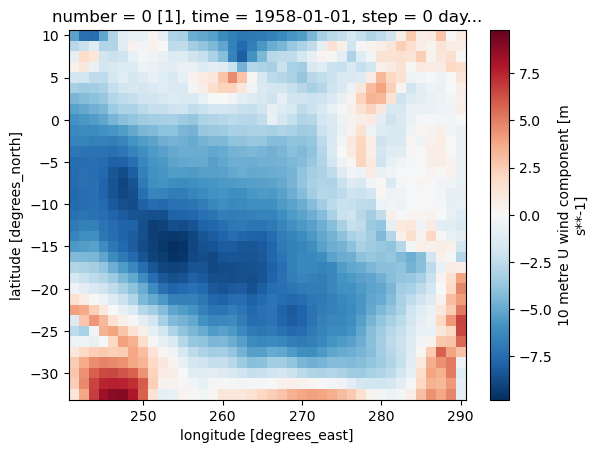

In [32]:
ds_JRA2.isel(time=0).u10.sel(latitude=slice(*lats), longitude=slice(*lons)).plot()

In [33]:
JA = ds_JRA2.isel(time=0).u10.sel(latitude=slice(*lats), longitude=slice(*lons))
JA['longitude']=JA.longitude -360
JA

<xarray.DataArray 'u10' (latitude: 35, longitude: 40)> Size: 6kB
array([[-5.2066193 , -7.3316193 , -7.4409943 , ...,  2.8090057 ,
        -0.14411926,  0.88713074],
       [-2.7222443 , -2.2066193 , -1.2222443 , ...,  1.3090057 ,
         0.76213074,  0.63713074],
       [-0.86286926,  1.7777557 ,  1.1996307 , ...,  1.1058807 ,
         1.6840057 ,  0.10588074],
       ...,
       [ 2.6840057 ,  4.5121307 ,  5.8402557 , ...,  3.4652557 ,
         4.9808807 , -1.1753693 ],
       [ 2.4340057 ,  4.6996307 ,  6.6215057 , ...,  3.2465057 ,
         4.2152557 , -0.94099426],
       [ 1.2152557 ,  3.8090057 ,  6.7465057 , ...,  3.8090057 ,
         4.7621307 , -1.0191193 ]], dtype=float32)
Coordinates:
    number             int64 8B 0
    time               datetime64[ns] 8B 1958-01-01
    step               timedelta64[ns] 8B 00:00:00
    heightAboveGround  float64 8B 10.0
  * latitude           (latitude) float64 280B 10.0 8.75 7.5 ... -31.25 -32.5
    valid_time         datetime64[ns] 8B 1958-01-01
  * longitude          (longitude) float64 320B -118.8 -117.5 ... -71.25 -70.0
Attributes: (12/31)
    GRIB_paramId:                             165
    GRIB_dataType:                            0
    GRIB_numberOfPoints:                      41760
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           10u
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            eastward_wind

In [34]:
# Step 3: Create the target fine grid (lon=602, lat=542)
lon_fine = np.linspace(lon.values.min(), lon.values.max(), 602) # 602 longitude points
lat_fine = np.linspace(lat.values.min(), lat.values.max(), 542)  # 542 latitude points
lon_grid_fine, lat_grid_fine = np.meshgrid(lon_fine, lat_fine)

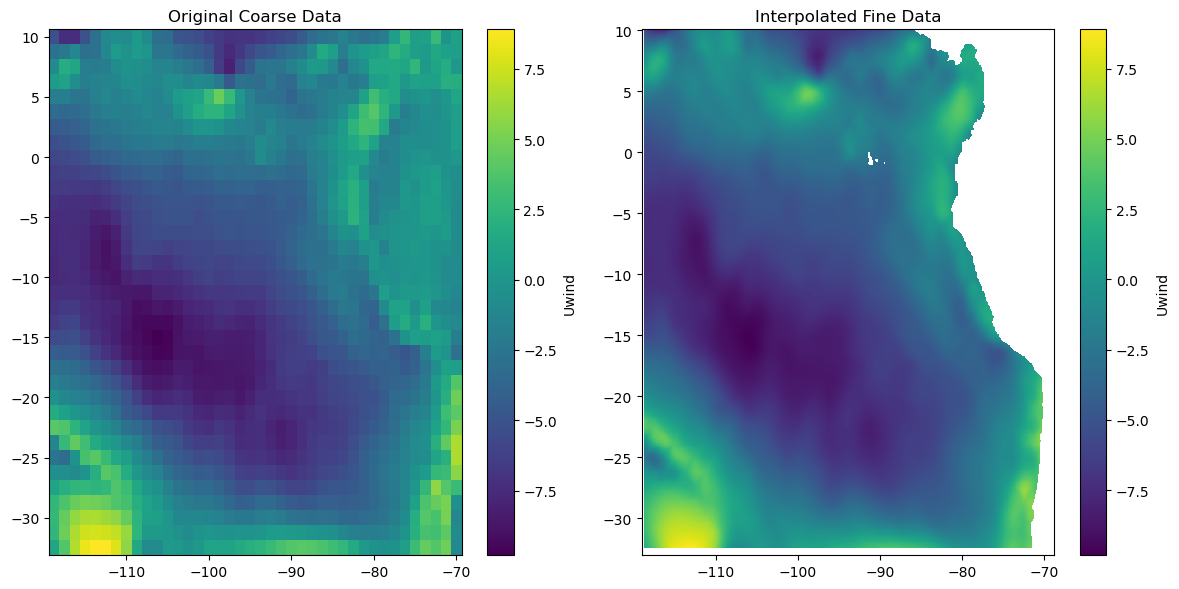

In [41]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Step 1: Create the original coarse grid (lon=40, lat=35)
lon_coarse = JA.longitude.values.flatten()  # 40 longitude points
lat_coarse = JA.latitude.values.flatten()  # 35 latitude points
lon_grid_coarse, lat_grid_coarse = np.meshgrid(lon_coarse, lat_coarse)

# Step 2: Generate some sample data on the coarse grid (e.g., temperature)
# Here, we create a synthetic dataset for demonstration
data_coarse = JA.values

# Step 3: Create the target fine grid (lon=602, lat=542)
lon_fine = lon[0,:].values.flatten() # 602 longitude points
lat_fine = lat[:,0].values.flatten()  # 542 latitude points
lon_grid_fine, lat_grid_fine = np.meshgrid(lon_fine, lat_fine)

# Step 4: Flatten the coarse grid coordinates and data for interpolation
coords_coarse = np.column_stack((lon_grid_coarse.flatten(), lat_grid_coarse.flatten()))
data_coarse_flat = data_coarse.flatten()

# Step 5: Flatten the target fine grid coordinates
coords_fine = np.column_stack((lon_grid_fine.flatten(), lat_grid_fine.flatten()))

# Step 6: Perform interpolation (linear or cubic)
data_fine_flat = griddata(
    coords_coarse,  # Original coordinates (shape: (40*35, 2))
    data_coarse_flat,  # Original data (shape: (40*35,))
    coords_fine,  # Target coordinates (shape: (602*542, 2))
    method='cubic'  # or 'cubic' for smoother results
)

# Step 7: Reshape the interpolated data to the fine grid shape
data_fine = data_fine_flat.reshape((542, 602))
# Step 8: Visualize the results
plt.figure(figsize=(12, 6))

# Plot original coarse data
plt.subplot(1, 2, 1)
plt.pcolormesh(lon_grid_coarse, lat_grid_coarse, data_coarse, shading='auto')
plt.title("Original Coarse Data")
plt.colorbar(label="Uwind")

# Plot interpolated fine data
plt.subplot(1, 2, 2)
plt.pcolormesh(lon_grid_fine, lat_grid_fine, data_fine*mask, shading='auto')
plt.title("Interpolated Fine Data")
plt.colorbar(label="Uwind")

plt.tight_layout()
plt.show()

In [ ]:
 u_interp = ds_u.u.isel(elem=grid_elems - 1).sel(nz1=z_target,method = 'nearest') 